In [1]:
import pandas as pd
import numpy as np
from datetime import date

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

date=str(date.today())
date = '2020-11-03'

In [2]:
#####################################
# Read
#####################################
# Read
df = pd.read_parquet(f'transformed/extraction_{date}.parquet')

y_col = 'price'
X_cols = list(set(df.columns) - set([y_col]))
y, X = df[y_col].values, df[X_cols]

#####################################
# Feature engineering
#####################################
# Extract columns 
all_cols = X.columns
cat_cols = all_cols[X.dtypes == 'object']
cat_cols = cat_cols.append(all_cols[X.dtypes == 'bool'])
for c in cat_cols:
    X[c]=X[c].astype(str)

num_cols = all_cols[X.dtypes == 'float64']
num_cols = num_cols.append(all_cols[X.dtypes == 'int64'])
X = X[num_cols.append(cat_cols)]

# Process features
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                              ('scaler', StandardScaler())])
        
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
                                            ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])

preprocessor = ColumnTransformer(transformers=[ ('num', numeric_transformer, num_cols), 
                                                ('cat', categorical_transformer, cat_cols)])

X_transformed = preprocessor.fit_transform(X)
#####################################
# Model
#####################################
# Model
elasticnet = ElasticNetCV(cv=5, fit_intercept=True, random_state=0)

# Declare pipeline
pipe = Pipeline(steps=[('FE', preprocessor), ('elasticnet', elasticnet)])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('FE',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                                       

In [3]:
cross_val_score(pipe, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)

array([-0.11576342, -0.13151823, -0.11490385])

In [4]:
pipe.score(X_test, y_test)

0.5832291798845437

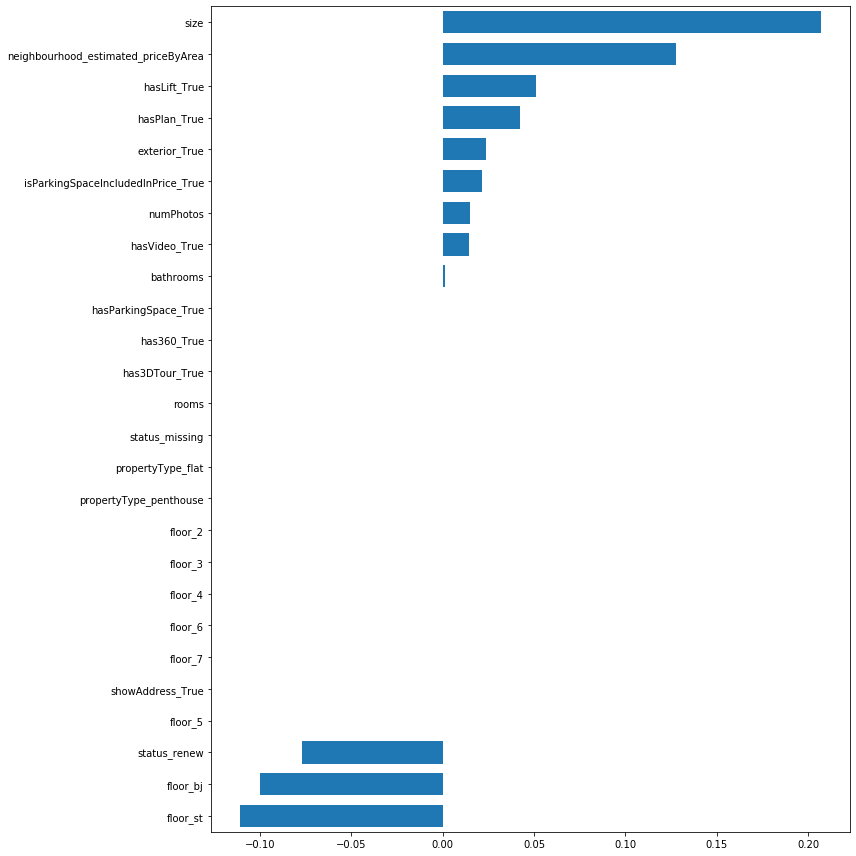

In [5]:
# Get names
trans_cat_cols = pipe.named_steps['FE'].transformers_[1][1].named_steps['onehot'].get_feature_names(cat_cols)
transformed_features_names = list(num_cols) + list(trans_cat_cols)

# Get importances
importances = pipe['elasticnet'].coef_

# Plot
perm_sorted_idx = importances.argsort()
importance_sorted_idx = np.argsort(importances)
indices = np.arange(0, len(importances)) + 0.5

fig, ax1 = plt.subplots(figsize=(12, 12))
ax1.barh(indices,
         importances[importance_sorted_idx], height=0.7)
ax1.set_yticklabels(np.array(transformed_features_names)[importance_sorted_idx])
ax1.set_yticks(indices)
ax1.set_ylim((0, len(importances)))
fig.tight_layout()
plt.show()

In [6]:
df_final = X_test
df_final['realPrice'] = y_test
df_final['predPrice'] = pipe.predict(X_test)

In [7]:
df_final['diff'] = (df_final['realPrice'] - df_final['predPrice'])/df_final['realPrice']
cheap_houses = df_final[df_final.realPrice < np.log(200000+1)].sort_values(by='diff').tail(5).index.values

df_original = pd.read_csv(f'extractions/extraction_{date}.csv', dtype={'propertyCode':str})
df_original[df_original.propertyCode.isin(cheap_houses)]


,Unnamed: 0,index,address,bathrooms,country,detailedType,distance,district,exterior,externalReference,...,propertyType,province,rooms,showAddress,size,status,suggestedTexts,thumbnail,topNewDevelopment,url
330,330,30,Calle de Oltra,1,es,{'typology': 'flat'},2462,Barrio de Salamanca,True,1543/290,...,flat,Madrid,1,False,36.0,good,"{'subtitle': 'Guindalera, Madrid', 'title': 'P...",https://img3.idealista.com/blur/WEB_LISTING/0/...,False,https://www.idealista.com/inmueble/90236877/
435,435,35,"Velarde, 16",1,es,{'typology': 'flat'},1279,Centro,True,VELARDE 16,...,flat,Madrid,1,True,24.0,renew,"{'subtitle': 'Malasaña-Universidad, Madrid', '...",https://img3.idealista.com/blur/WEB_LISTING/0/...,False,https://www.idealista.com/inmueble/91606603/
483,483,33,"Calle de Santa Engracia, 79",1,es,{'typology': 'flat'},581,Chamberí,False,NaN,...,flat,Madrid,2,True,36.0,renew,"{'subtitle': 'Trafalgar, Madrid', 'title': 'Pi...",https://img3.idealista.com/blur/WEB_LISTING/90...,False,https://www.idealista.com/inmueble/91596035/
677,677,27,"Calle de los Molinos, 3",1,es,{'typology': 'flat'},2709,Tetuán,True,8161,...,flat,Madrid,2,True,44.0,good,"{'subtitle': 'Berruguete, Madrid', 'title': 'P...",https://img3.idealista.com/blur/WEB_LISTING/0/...,False,https://www.idealista.com/inmueble/91554655/
930,930,30,Calle de Santa Engracia,1,es,{'typology': 'flat'},669,Chamberí,False,VEN7448M,...,flat,Madrid,2,False,37.0,renew,"{'subtitle': 'Trafalgar, Madrid', 'title': 'Pi...",https://img3.idealista.com/blur/WEB_LISTING/0/...,False,https://www.idealista.com/inmueble/91499667/
